# Dependencies

In [23]:
#!pip install -r requirements.txt

In [24]:
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import gensim.downloader as api

from itertools import permutations

from gensim.utils import tokenize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

from tqdm import tqdm

os.environ["GENSIM_DATA_DIR"] = '.\\gensim'

# Loading Data

In [25]:
df_train = pd.read_csv('./data/learn-ai-bbc/BBC News Train.csv')
df_test = pd.read_csv('./data/learn-ai-bbc/BBC News Test.csv')

In [26]:
df_train, df_eval = train_test_split(df_train, test_size=0.2)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1192 entries, 889 to 1098
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1192 non-null   int64 
 1   Text       1192 non-null   object
 2   Category   1192 non-null   object
dtypes: int64(1), object(2)
memory usage: 37.2+ KB


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [29]:
df_train.head()

,ArticleId,Text,Category
889,202,profits stall at china s lenovo profits at chi...,business
1167,1005,critics back aviator for oscars martin scorses...,entertainment
1192,1388,parker s saxophone heads auction a saxophone b...,entertainment
1301,288,peers debate crown succession law peers are de...,politics
655,542,mumbai bombs movie postponed the release of a ...,entertainment


In [30]:
df_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


# PreProcessing

To begin with , let's create a mapping of the different categories to indices

In [31]:
categories = df_train['Category'].unique()
categories = dict(zip(range(len(categories)), categories))
reverse_categories = {v:k for k,v in categories.items()}

Filtering out stop words since they are not as relavant for classification

In [32]:
df_train['text_clean'] = df_train['Text'].apply(lambda s: remove_stopwords(s))
df_test['text_clean'] = df_test['Text'].apply(lambda s: remove_stopwords(s))
df_eval['text_clean'] = df_eval['Text'].apply(lambda s: remove_stopwords(s))

We'll use bag of words count followed by TF-IDF

In [33]:
counter = CountVectorizer()
tfidf = TfidfTransformer()

bow_vec = counter.fit_transform(df_train['text_clean'])
tfidf_vec = tfidf.fit_transform(bow_vec)

bow_vec_eval = counter.transform(df_eval['text_clean'])
tfidf_vec_eval = tfidf.transform(bow_vec_eval)

In [34]:
vocab = counter.vocabulary_
reverse_vocab = {v:k for (k,v) in vocab.items()}

In [35]:
# Sanity
#print(list(map(lambda x: reverse_vocab[x], np.where(bow_vec[0].todense() > 0)[1])))
#print(df_train['text_clean'].iloc[0])

# EDA

Let's examine the document count in each category

<Axes: >

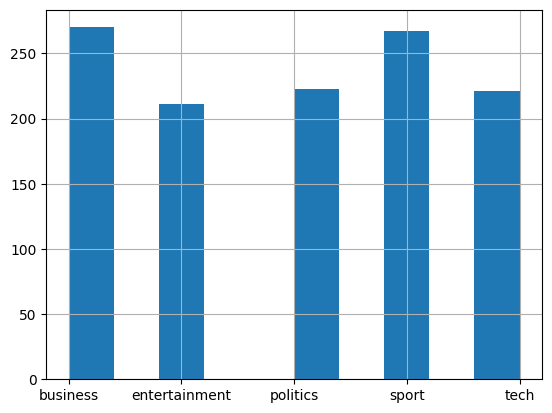

In [36]:
df_train['Category'].hist()

Summing up the rows of our word count matrix to get the total word count in the dataset

In [37]:
word_counts_total = bow_vec.sum(axis=0)
word_frequencies = [(reverse_vocab[i],word_counts_total[0,i]) for i in range(len(vocab))]

Let's see which words are the most popular

In [38]:
top_words = pd.DataFrame(sorted(word_frequencies, key=lambda x:x[1], reverse=True), columns=['word','frequency'])
top_words

,word,frequency
0,said,3883
1,mr,1551
2,year,1217
3,people,1090
4,new,1065
...,...,...
22544,zodiac,1
22545,zoellick,1
22546,zooropa,1
22547,zuluaga,1


And how is the word count distributed? We have to log-transform for the visualization to make sense

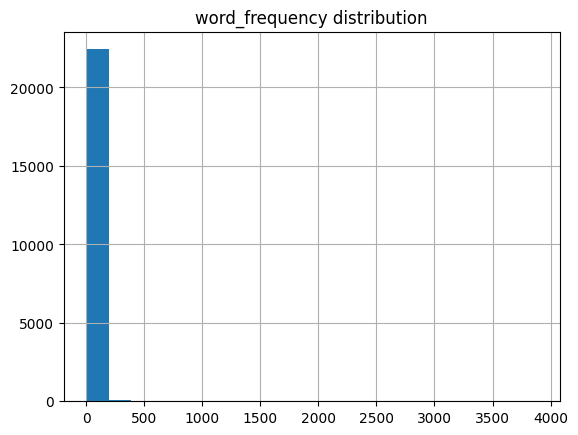

In [39]:

top_words['frequency'].hist(bins=20)
plt.title("word_frequency distribution")
plt.show()

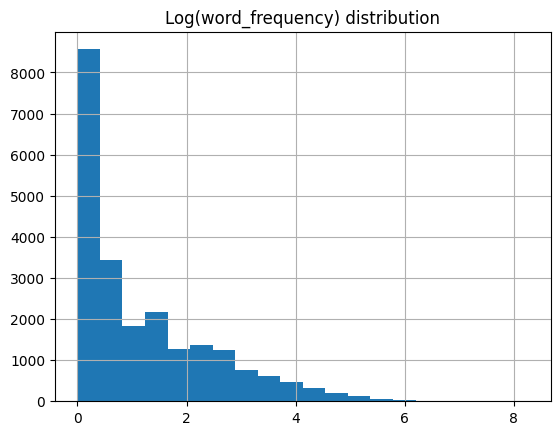

In [40]:

top_words['frequency'].apply(np.log).hist(bins=20)
plt.title("Log(word_frequency) distribution")
plt.show()

# Supervised Approach

In order to represent our documents as vectors, we will utilize word2vec and get the mean vector for each document.
Averaging the word embedding vectors, is one way to create a document embedding. The produced vector should capture some of the semantic meaning of the document , and with it information about the topic at hand.

In [41]:
wv = api.load('word2vec-google-news-300')

In [42]:
def doc_embedding(text):
	tokens = tokenize(text)
	return np.mean([wv[t] for t in tokens if t in wv], axis=0)

# test_doc = df_train['text_clean'].iloc[0]
# print(test_doc)
# doc_embedding(test_doc)

We create our utility matrix both for training and testing datasets, retrieving all documents embeddings

In [43]:
util_matrix_train = np.zeros((len(df_train), wv.vector_size))
util_matrix_test = np.zeros((len(df_test), wv.vector_size))
util_matrix_eval = np.zeros((len(df_eval), wv.vector_size))

for i,doc in tqdm(enumerate(df_train['text_clean'])):
    util_matrix_train[i] = doc_embedding(doc)


util_matrix_eval = np.zeros((len(df_eval), wv.vector_size))
for i,doc in tqdm(enumerate(df_eval['text_clean'])):
    util_matrix_eval[i] = doc_embedding(doc)
    
util_matrix_test = np.zeros((len(df_test), wv.vector_size))
for i,doc in tqdm(enumerate(df_test['text_clean'])):
    util_matrix_test[i] = doc_embedding(doc)

1192it [00:01, 1131.10it/s]
298it [00:00, 1072.46it/s]
735it [00:00, 1172.27it/s]


In [44]:
print(util_matrix_train.shape)
print(util_matrix_eval.shape)
print(util_matrix_test.shape)

(1192, 300)
(298, 300)
(735, 300)


Now we can train a model using supervised learning approaches, let's try KNN

We will have to iterate over the permutations of the labels in order to find out which ones are the correct, this will serve us mainly in the unsupervised method

In [45]:
def find_perm(predicted_labels, df):
    best_acc = 0
    best_perm = None
    
    for perm in permutations(categories.values()):
        reverse_categories = {v:k for k,v in enumerate(perm)}
        true_labels = df['Category'].map(reverse_categories)
        acc = accuracy_score(predicted_labels, true_labels)
    
        if acc > best_acc:
            best_perm = perm
            best_acc = acc

    return best_acc, best_perm

Since we're using word2vec it is better to consider cosine distance metric, in addition we will test different number of N values for the model to find the optimal hyper-parameter

In [75]:
N_VALUES = list(range(1,20,2))
train_scores = []
test_scores = []

for n in tqdm(N_VALUES):
    model = KNeighborsClassifier(n_neighbors=n, metric='cosine')
    model.fit(util_matrix_train, y=df_train['Category'].map(reverse_categories))
    predicted_labels = model.predict(util_matrix_train)
    
    best_acc, best_perm = find_perm(predicted_labels, df_train)
    train_scores.append(best_acc)
    #print(f"N={n}")
    #print(f"Training score: {best_acc}")
    
    predicted_labels = model.predict(util_matrix_eval)
    best_acc, best_perm = find_perm(predicted_labels, df_eval)
    test_scores.append(best_acc)

    #print(f"Eval score: {best_acc}")
    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


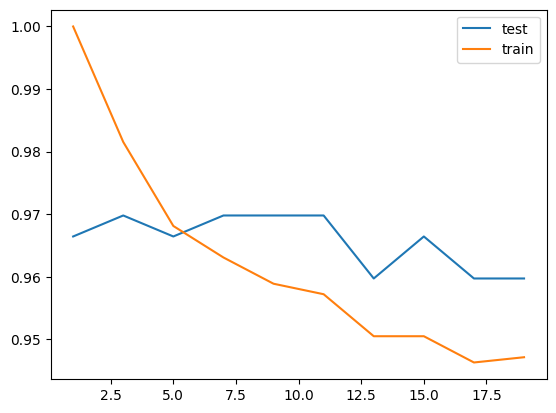

In [76]:
plt.plot(N_VALUES, test_scores, label='test')
plt.plot(N_VALUES, train_scores, label='train')
plt.legend()
plt.show()

It seems that after n=10 our performances are actually getting worse, so  we can conclude based on that graph that the best range of values are between n=7 and n=10

In [80]:
print(f"Best score from KNN: {max(test_scores)}")

Best score from KNN: 0.9697986577181208


# Unsupervised Approach

We will use NMF and decompose the matrix into 5 components, since we have 5 categories

In [89]:
nmf_model = NMF(n_components=len(categories)) 

nmf_model.fit(tfidf_vec)
W_train = nmf_model.transform(tfidf_vec)
W_eval = nmf_model.transform(tfidf_vec_eval)
H = nmf_model.components_

In [90]:
predicted_train = np.argmax(W_train, axis=1)
predicted_eval = np.argmax(W_eval, axis=1)

In [91]:
find_perm(predicted_train, df_train)

(0.9169463087248322,
 ('sport', 'politics', 'tech', 'entertainment', 'business'))

In [92]:
find_perm(predicted_eval, df_eval)

(0.9161073825503355,
 ('sport', 'politics', 'tech', 'entertainment', 'business'))

# Interpretation

It seems like both the supervised and unsupervised approaches yielded pretty good performance in the training set, although the supervised approached using word2vec did perform better. Using NMF we couldn't utilize the power of word embeddings because the embedding vectors contain negative values.

Validation score on KNN + Word2Vec with mean pooling - 97%

Validation score on TF-IDF followed by NMF - 91.6%